# Create road networks that take into account the interventions 

The intervening scenarios are removed from the original road network.

In [10]:
# load libraries

import pandas as pd
import geopandas as gpd
import networkx as nx
import osmnx as ox
import os
import shapely
import matplotlib.pyplot as plt
import itertools
import json

In [2]:
# load data

# set crs for Tokyo
crs = 'EPSG:6677'

# load geometry for the area of interest
tokyo_geom = gpd.read_file(os.path.join('data', 'tokyo_boundaries', 'N03-20240101_13.shp'))
tokyo_geom = tokyo_geom[tokyo_geom['N03_004'].str.contains('区')].copy().to_crs(crs)

In [3]:
# load network
tokyo_drive_network = ox.load_graphml(os.path.join('data', 'tokyo', 'drive_network_updated.graphml'))

In [4]:
# fix the data type

for u, v, k, d in tokyo_drive_network.edges(data = True, keys = True):
    # convert wkt to geometry
    if 'geometry' in d.keys() and isinstance(d['geometry'], str):
        d['geometry'] = shapely.wkt.loads(d['geometry'])
    # convert to numeric
    for c in ['speed_kph', 'travel_time', 'travel_time_mins', 'speed_kph_calib', 'travel_time_calib', 'travel_time_mins_calib']:
        d[c] = float(d[c])  

for n, d in tokyo_drive_network.nodes(data = True):
    # convert wkt to geometry
    if 'geometry' in d.keys() and isinstance(d['geometry'], str):
        d['geometry'] = shapely.wkt.loads(d['geometry'])

In [5]:
[n for n in tokyo_drive_network.edges(data = True)][:10]

[(31236562,
  7658031749,
  {'osmid': 316305908,
   'bridge': 'yes',
   'oneway': True,
   'lanes': '2',
   'ref': '11',
   'name': '首都高速11号台場線・東京港連絡橋',
   'highway': 'motorway',
   'reversed': False,
   'length': 41.081,
   'speed_kph': 60.6,
   'geometry': <LINESTRING (-6714.703 -40172.278, -6698.814 -40179.401, -6676.786 -40188.226)>,
   'travel_time': 2.4,
   'travel_time_mins': 0.04,
   'speed_kph_calib': 28.83848378687951,
   'travel_time_calib': 5.043260979835911,
   'travel_time_mins_calib': 0.08405434966393185}),
 (31236646,
  573342136,
  {'osmid': 333682057,
   'bridge': 'yes',
   'oneway': True,
   'highway': 'tertiary',
   'reversed': False,
   'length': 40.061,
   'speed_kph': 33.7,
   'travel_time': 4.3,
   'travel_time_mins': 0.07166666666666667,
   'speed_kph_calib': 16.03724263395775,
   'travel_time_calib': 9.035842588872674,
   'travel_time_mins_calib': 0.15059737648121124}),
 (573342136,
  7658921698,
  {'osmid': 23681347,
   'bridge': 'yes',
   'oneway': True,
   

## Create the edge list to remove from the network

In [6]:
# load interventions 
interventions = gpd.read_file(os.path.join('data', 'tokyo', 'interventions', 'current_scenarios.gpkg')).to_crs(crs)
chuo_dori = gpd.read_file(os.path.join('data', 'tokyo', 'interventions', 'chuo_dori.gpkg')).to_crs(crs)

In [7]:
# organise into dictionary
aoi = {}

areas = ['Ginza', 'Akihabara', 'Shinjuku']
for area in areas:
    aoi[area] = interventions[interventions['area'] == area].unary_union

aoi['Chuo_dori'] = chuo_dori.unary_union
aoi['all'] = interventions.unary_union

In [8]:
# remove nodes
threshold = 15

# initialise nodes
remove_nodes = {}

remove_edges = {}

for area, geom in aoi.items():
    # initialise list
    remove_nodes[area] = []
    print(f'Calculating for {area}...')

    # calculate the distances
    for n ,d in tokyo_drive_network.nodes(data = True):
        point = shapely.Point(d['x'], d['y'])
        if shapely.dwithin(geom, point, threshold):
            remove_nodes[area].append(n)
    
    remove_edges[area] = [(u,v) for u,v,k in tokyo_drive_network.subgraph(remove_nodes[area]).edges(data = True) if k['length'] > 30]   



Calculating for Ginza...
Calculating for Akihabara...
Calculating for Shinjuku...
Calculating for Chuo_dori...
Calculating for all...


In [11]:
# save these as json
with open('data/tokyo/remove_edges.json', 'w') as f:
    json.dump(remove_edges, f)
    
with open('data/tokyo/remove_nodes.json', 'w') as f:
    json.dump(remove_nodes, f)

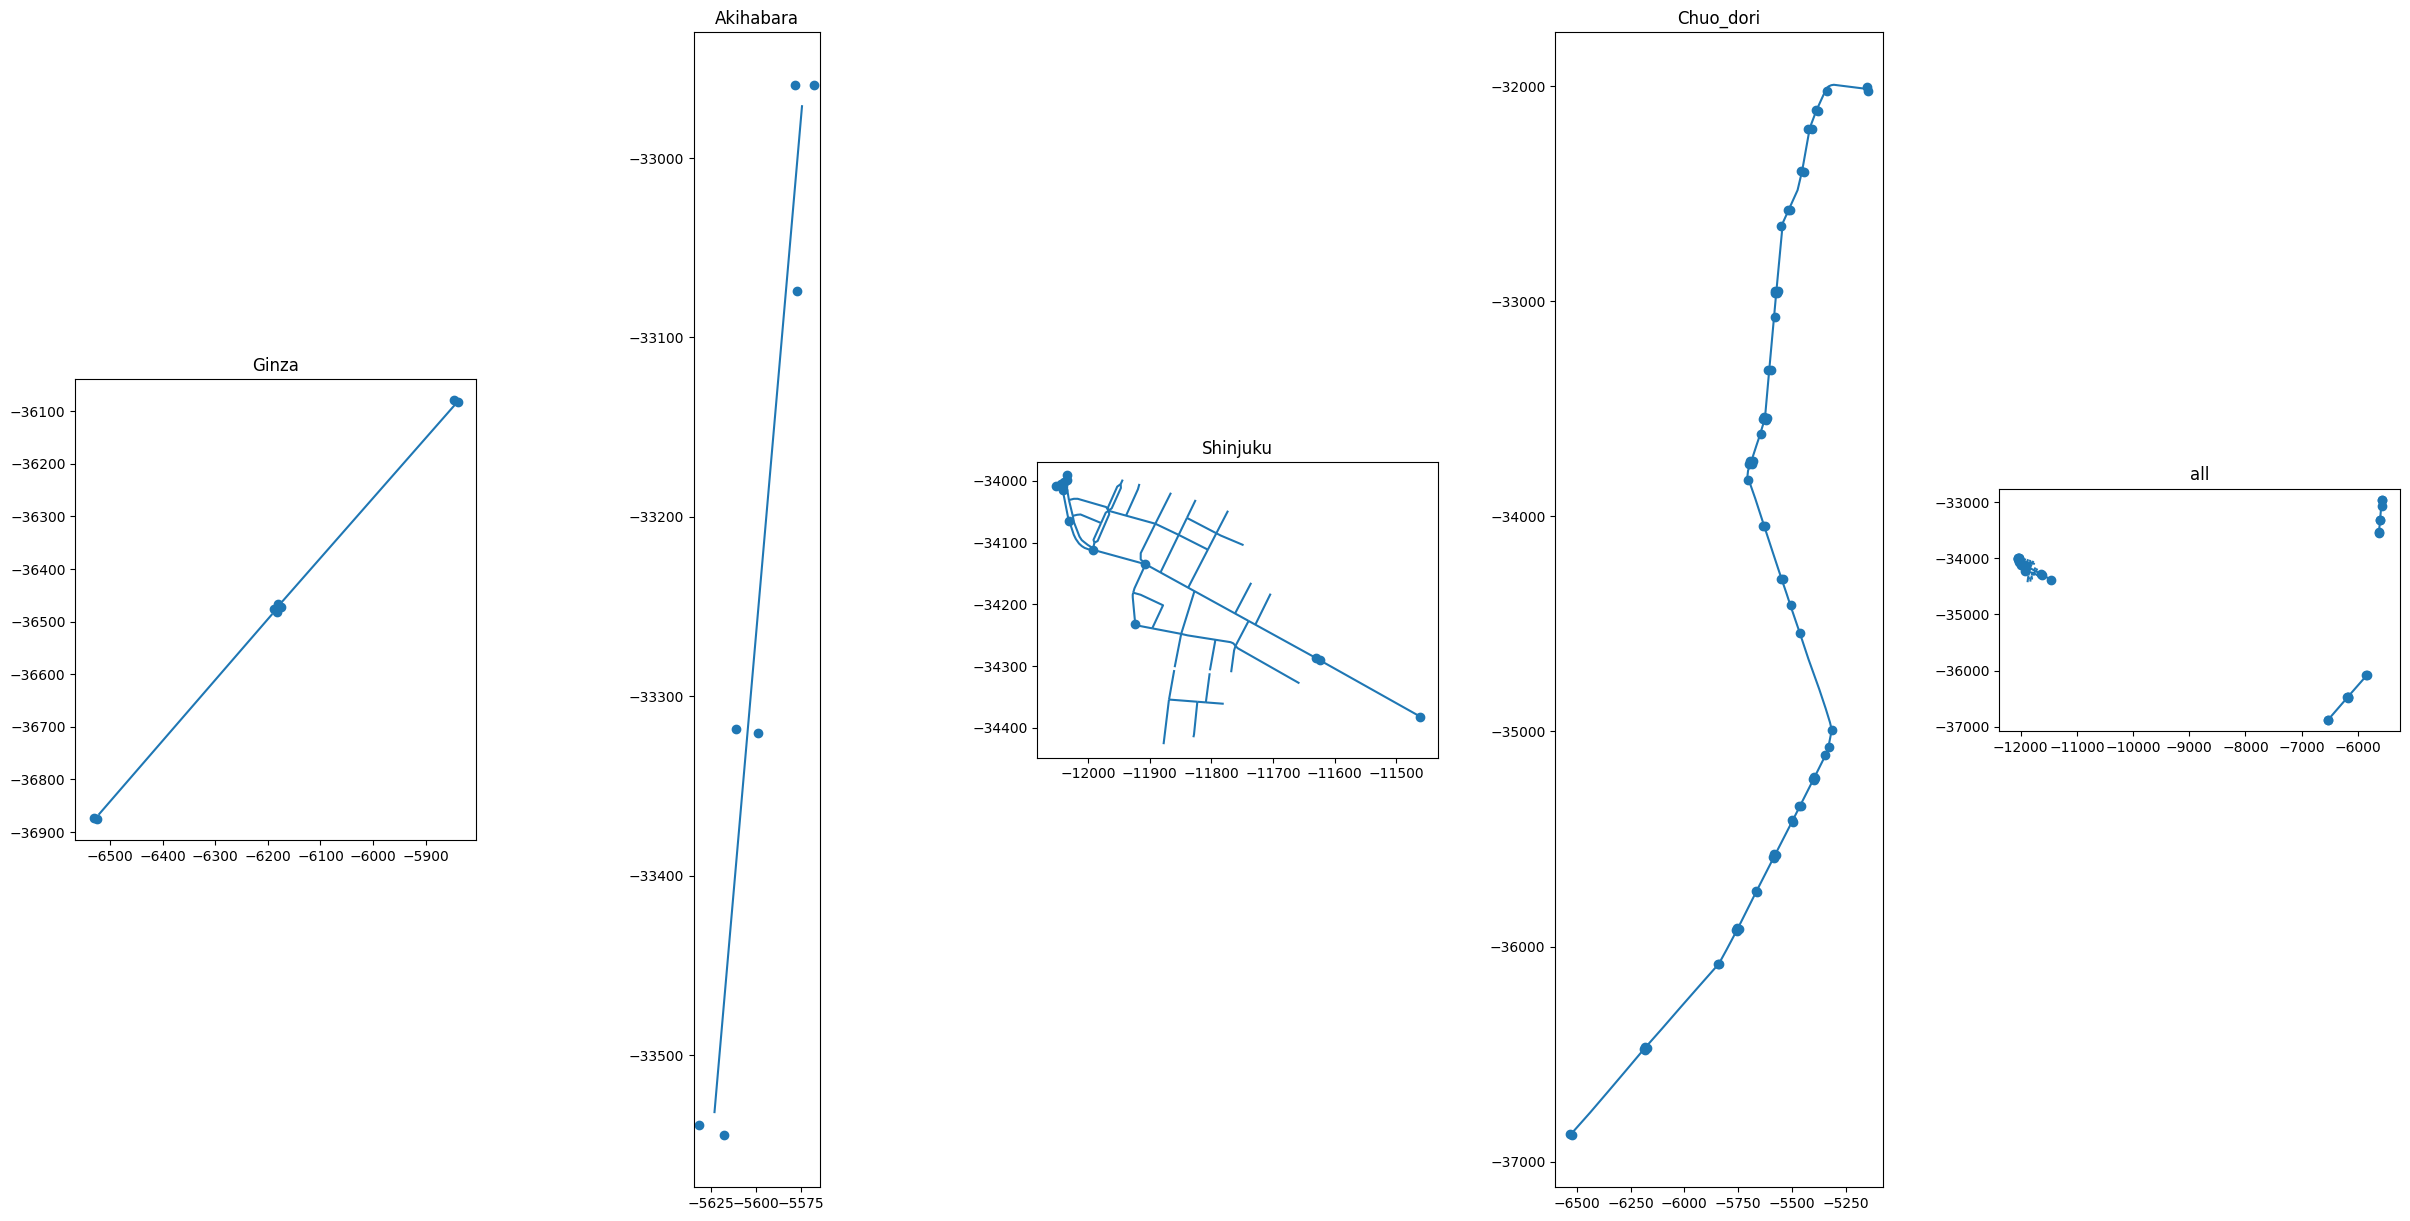

In [9]:
# initialise plot
fig, axes = plt.subplots(1, len(aoi), figsize = (30,15))

for idx, area in enumerate(aoi.keys()):
    ax = axes[idx]

    # get points
    points = [(d['x'], d['y']) for n,d in tokyo_drive_network.nodes(data = True) if n in remove_nodes[area]]
    x, y = zip(*[(point[0], point[1]) for point in points])

    ax.scatter(x, y)
    gpd.GeoSeries(aoi[area], crs = crs).plot(ax = ax)

    ax.set_title(area)


## Remove edges from the network

In [10]:
removed_network = {}

for area, value in remove_edges.items():
    # copy the network
    removed_network[area] = tokyo_drive_network.copy()
    # create a removed network
    removed_network[area].remove_edges_from(value)



# get the largest strongly connected network
tokyo_drive_network = ox.truncate.largest_component(tokyo_drive_network, strongly = True)

for area in removed_network:
    removed_network[area] = ox.truncate.largest_component(removed_network[area], strongly = True)

In [11]:
[len(g.edges) for i, g in removed_network.items()]

[29939, 29938, 29929, 29883, 29920]

## Remove nodes entirely to see the difference

For the Chuo_dori thing, remove the entire things to see what happens.

In [12]:
# create network without the nodes
for area, nodes in remove_nodes.items():
    removed_network[f'{area}_nodes'] = tokyo_drive_network.copy()
    removed_network[f'{area}_nodes'].remove_nodes_from(nodes)

    # get the largest connecting component
    removed_network[f'{area}_nodes'] = ox.truncate.largest_component(removed_network[f'{area}_nodes'], strongly = True)

## Connect the zones to the nearest point

In [13]:
# load the area data
zones = gpd.read_file(os.path.join('data', 'H30_gis', 'H30_kzone.shp'))

# extract the Tokyo Metropolitan Area
zones_tokyo = zones[zones['kzone'] < 700]

# create zone list
zones_dict = []
for idx, area in zones_tokyo.iterrows():
    node_id = 'zone_' + str(area['kzone'])
    c = area['geometry'].centroid
    y = c.y
    x = c.x
    zones_dict.append((node_id, {
        'y': y,
        'x': x,
        'zone_int': area['kzone'],
        'zone_name': node_id
    }))

In [14]:
# add the zones to the network
# the centroid of the zones will be connected to the network to the nearest node

def add_zones(G, zones):
    edge_dict = []
    for z in zones:
        id = z[0]
        data = z[1]
        nearest_node = ox.nearest_nodes(G, data['x'], data['y'], return_dist = True)
        data_dict = {
            'length': nearest_node[1],
            'travel_time_mins': 0.1,
            'travel_time_mins_calib': 0.1,
            'type': 'connection'
        }
        edge_dict.append((id, nearest_node[0], data_dict))
        edge_dict.append((nearest_node[0], id, data_dict))
        
    G.add_nodes_from(zones)
    G.add_edges_from(edge_dict)

In [15]:
%%time

# add zones to all the networks
add_zones(tokyo_drive_network, zones_dict)
for idx, g in removed_network.items():
    print(f'Processing {idx}')
    add_zones(g, zones_dict)

Processing Ginza
Processing Akihabara
Processing Shinjuku
Processing Chuo_dori
Processing all
Processing Ginza_nodes
Processing Akihabara_nodes
Processing Shinjuku_nodes
Processing Chuo_dori_nodes
Processing all_nodes
CPU times: total: 1min 16s
Wall time: 2min 36s


In [16]:
# read from pickle
od_matrix_tokyo = pd.read_pickle('data/tokyo/pt_network_time_weight_updated.pkl')

In [17]:
# get the shortest paths for all the zones
zones_list = [n for n,d in zones_dict]

In [18]:
# initialise dictionary
drive_distance_dict = {
    'orig': {}
}
drive_path = {
    'orig': {}
}

# calculate the distance
for u in zones_list:
    distance, path = nx.single_source_dijkstra(tokyo_drive_network, source = u, weight='travel_time_mins')
    for v, dist in distance.items():
        if 'zone' in str(v): 
            drive_distance_dict['orig'][(u, v)] = dist
    for v, p in path.items():
        if 'zone' in str(v): 
            drive_path['orig'][(u, v)] = p


# calculate for the other networks as well
for area, g in removed_network.items():
    print(f'Calculating {area}')
    drive_distance_dict[f'removed_{area}'] = {}
    drive_path[f'removed_{area}'] = {}
    # calculate the distance
    for u in zones_list:
        distance, path = nx.single_source_dijkstra(g, source = u, weight='travel_time_mins')
        for v, dist in distance.items():
            if 'zone' in str(v): 
                drive_distance_dict[f'removed_{area}'][(u, v)] = dist
        for v, p in path.items():
            if 'zone' in str(v): 
                drive_path[f'removed_{area}'][(u, v)] = p
        

Calculating Ginza
Calculating Akihabara
Calculating Shinjuku
Calculating Chuo_dori
Calculating all
Calculating Ginza_nodes
Calculating Akihabara_nodes
Calculating Shinjuku_nodes
Calculating Chuo_dori_nodes
Calculating all_nodes


In [19]:
drive_distance_dict.keys()

dict_keys(['orig', 'removed_Ginza', 'removed_Akihabara', 'removed_Shinjuku', 'removed_Chuo_dori', 'removed_all', 'removed_Ginza_nodes', 'removed_Akihabara_nodes', 'removed_Shinjuku_nodes', 'removed_Chuo_dori_nodes', 'removed_all_nodes'])

In [20]:
drive_path['removed_Ginza']

{('zone_430', 'zone_430'): ['zone_430'],
 ('zone_430', 'zone_431'): ['zone_430',
  8269971143,
  307676170,
  307676147,
  307676144,
  307676132,
  1230868491,
  1093653848,
  279077132,
  278281065,
  278274363,
  519946869,
  617975487,
  519946899,
  519948474,
  2359268290,
  'zone_431'],
 ('zone_430', 'zone_421'): ['zone_430',
  8269971143,
  307676170,
  307676147,
  307676144,
  307676132,
  307676130,
  307676137,
  307676139,
  8269971144,
  8269971142,
  278281085,
  262602069,
  443664947,
  279077025,
  2379714007,
  410466781,
  2251353244,
  410134384,
  410134680,
  253116433,
  476574837,
  2379706224,
  'zone_421'],
 ('zone_430', 'zone_436'): ['zone_430',
  8269971143,
  307676170,
  364680799,
  358459901,
  360666930,
  364672175,
  381414874,
  366198528,
  480766386,
  502928493,
  1033253686,
  1033273181,
  502938320,
  502948716,
  897317143,
  897317147,
  'zone_436'],
 ('zone_430', 'zone_437'): ['zone_430',
  8269971143,
  307676170,
  364680799,
  358459901,

In [21]:
drive_distance_dict['removed_Ginza']

{('zone_430', 'zone_430'): 0,
 ('zone_430', 'zone_431'): 5.323333333333334,
 ('zone_430', 'zone_421'): 6.093333333333333,
 ('zone_430', 'zone_436'): 6.165,
 ('zone_430', 'zone_437'): 6.51,
 ('zone_430', 'zone_112'): 7.011666666666666,
 ('zone_430', 'zone_243'): 7.015,
 ('zone_430', 'zone_241'): 8.08,
 ('zone_430', 'zone_111'): 8.208333333333332,
 ('zone_430', 'zone_432'): 8.225000000000001,
 ('zone_430', 'zone_412'): 8.235000000000001,
 ('zone_430', 'zone_242'): 8.713333333333335,
 ('zone_430', 'zone_110'): 9.163333333333332,
 ('zone_430', 'zone_422'): 9.499999999999998,
 ('zone_430', 'zone_233'): 9.883333333333335,
 ('zone_430', 'zone_30'): 10.336666666666668,
 ('zone_430', 'zone_435'): 10.441666666666666,
 ('zone_430', 'zone_120'): 10.556666666666667,
 ('zone_430', 'zone_411'): 10.87833333333333,
 ('zone_430', 'zone_232'): 10.973333333333334,
 ('zone_430', 'zone_434'): 11.094999999999997,
 ('zone_430', 'zone_433'): 11.25,
 ('zone_430', 'zone_231'): 11.508333333333335,
 ('zone_430', '

In [22]:
# organise into a dataframe to merge
distance_dict_all = {
    'source': [],
    'target': [],
}
for d in drive_distance_dict.keys():
    distance_dict_all[f'driving_time_{d}'] = []
for d in drive_path.keys():
    distance_dict_all[f'driving_path_{d}'] = []

for u in zones_list:
    u_int = int(u.replace('zone_', ''))
    for v in zones_list:
        v_int = int(v.replace('zone_', ''))

        distance_dict_all['source'].append(u_int)
        distance_dict_all['target'].append(v_int)

        for idx, dict in drive_distance_dict.items():
            distance = dict[(u,v)]
            distance_dict_all[f'driving_time_{idx}'].append(distance)
        for idx, dict in drive_path.items():
            path = dict[(u,v)]
            distance_dict_all[f'driving_path_{idx}'].append(path)
        


In [23]:
# merge with the matrix
od_matrix_merged = od_matrix_tokyo.merge(
    pd.DataFrame.from_dict(distance_dict_all),
    on = ['source', 'target'],
    how = 'left'
)

In [24]:
od_matrix_merged

,source,target,drive_time,drive_path,drive_time_calib,drive_path_calib,multilayer_time,multilayer_path,bus_time,bus_path,...,driving_path_removed_Ginza,driving_path_removed_Akihabara,driving_path_removed_Shinjuku,driving_path_removed_Chuo_dori,driving_path_removed_all,driving_path_removed_Ginza_nodes,driving_path_removed_Akihabara_nodes,driving_path_removed_Shinjuku_nodes,driving_path_removed_Chuo_dori_nodes,driving_path_removed_all_nodes
0,10,10,0.000000,[zone_10],0.000000,[zone_10],0.000000,[zone_10],0.000000,[zone_10],...,[zone_10],[zone_10],[zone_10],[zone_10],[zone_10],[zone_10],[zone_10],[zone_10],[zone_10],[zone_10]
1,10,11,3.905000,"[zone_10, 1588249099, 6483620518, 1588249091, ...",7.985534,"[zone_10, 1588249099, 6483620518, 1588249091, ...",25.415646,"[zone_10, street_1866774276, street_558686762,...",25.415646,"[zone_10, street_1866774276, street_558686762,...",...,"[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ..."
2,10,12,2.638333,"[zone_10, 1588249099, 236104886, 1072641884, 5...",5.323813,"[zone_10, 1588249099, 236104886, 1072641884, 5...",24.518493,"[zone_10, street_1866774276, street_558689164,...",25.910477,"[zone_10, street_1866774276, street_558689164,...",...,"[zone_10, 1588249099, 236104886, 1072641884, 5...","[zone_10, 1588249099, 236104886, 1072641884, 5...","[zone_10, 1588249099, 236104886, 1072641884, 5...","[zone_10, 1588249099, 236104886, 1072641884, 5...","[zone_10, 1588249099, 236104886, 1072641884, 5...","[zone_10, 1588249099, 236104886, 1072641884, 5...","[zone_10, 1588249099, 236104886, 1072641884, 5...","[zone_10, 1588249099, 236104886, 1072641884, 5...","[zone_10, 1588249099, 236104886, 1072641884, 5...","[zone_10, 1588249099, 236104886, 1072641884, 5..."
3,10,13,1.803333,"[zone_10, 1588249099, 6483620518, 1588249091, ...",3.569179,"[zone_10, 1588249099, 6483620518, 1588249091, ...",20.986065,"[zone_10, street_1866774276, street_558689164,...",20.986065,"[zone_10, street_1866774276, street_558689164,...",...,"[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ...","[zone_10, 1588249099, 6483620518, 1588249091, ..."
4,10,20,3.503333,"[zone_10, 1588249099, 6483620518, 257718001, 7...",7.141488,"[zone_10, 1588249099, 6483620518, 257718001, 7...",32.875049,"[zone_10, street_1866774276, street_558689164,...",35.320580,"[zone_10, street_1866774276, street_558689164,...",...,"[zone_10, 1588249099, 6483620518, 257718001, 7...","[zone_10, 1588249099, 6483620518, 257718001, 7...","[zone_10, 1588249099, 6483620518, 257718001, 7...","[zone_10, 1588249099, 6483620518, 257718001, 7...","[zone_10, 1588249099, 6483620518, 257718001, 7...","[zone_10, 1588249099, 6483620518, 257718001, 7...","[zone_10, 1588249099, 6483620518, 257718001, 7...","[zone_10, 1588249099, 6483620518, 257718001, 7...","[zone_10, 1588249099, 6483620518, 257718001, 7...","[zone_10, 1588249099, 6483620518, 257718001, 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13220,634,630,9.111667,"[zone_634, 2398403240, 2398403242, 600693446, ...",18.926609,"[zone_634, 2398403240, 2398403242, 600693446, ...",39.814964,"[zone_634, street_109

## Compare the performance

In [25]:
od_matrix_merged.filter(like = 'driving_time').sum()

driving_time_orig                       230940.900000
driving_time_removed_Ginza              231243.751667
driving_time_removed_Akihabara          230940.900000
driving_time_removed_Shinjuku           230940.900000
driving_time_removed_Chuo_dori          231336.935000
driving_time_removed_all                231243.751667
driving_time_removed_Ginza_nodes        231439.145000
driving_time_removed_Akihabara_nodes    230992.768333
driving_time_removed_Shinjuku_nodes     231052.676667
driving_time_removed_Chuo_dori_nodes    236149.780000
driving_time_removed_all_nodes          231603.073333
dtype: float64

So what this is saying is that:

- Removing the Ginza district has its impacts
- Other areas have no impact on the performance of the network

In [26]:
# save file
# od_matrix_merged.to_csv(os.path.join('data', 'tokyo', 'pt_network_time_scenarios_updated.csv'), index = False)
od_matrix_merged.to_pickle(os.path.join('data', 'tokyo', 'pt_network_time_scenarios_updated.pkl'))

## Calculate efficiency measures

Based on the number of people travelled, calculate the efficiency measure

$$
E(G) = \frac{1}{\sum n_{ij}} \sum_{i \ne j} \frac{n_{ij}}{d_{ij}}
$$

In [32]:
# initialise efficiency
efficiency_measures = {}

total_journeys = od_matrix_merged['vehicle'].sum()
for name, value in od_matrix_merged.items():
    if 'driving_time' in name:
        mask = (od_matrix_merged[name] > 0) 
        num = (od_matrix_merged[mask]['vehicle'] / od_matrix_merged[mask][name]).sum()

        efficiency_measures[name] = num / total_journeys

In [33]:
efficiency_measures

{'driving_time_orig': 0.10517078211341921,
 'driving_time_removed_Ginza': 0.10505639753149014,
 'driving_time_removed_Akihabara': 0.10517078211341921,
 'driving_time_removed_Shinjuku': 0.10517078211341921,
 'driving_time_removed_Chuo_dori': 0.10486790401565703,
 'driving_time_removed_all': 0.10505639753149014,
 'driving_time_removed_Ginza_nodes': 0.10493932340760317,
 'driving_time_removed_Akihabara_nodes': 0.10516390904688003,
 'driving_time_removed_Shinjuku_nodes': 0.10513663267558486,
 'driving_time_removed_Chuo_dori_nodes': 0.10312472199902131,
 'driving_time_removed_all_nodes': 0.10489817810002093}

In [34]:
# calculate the efficiency
efficiency_ratio = {}

for s in efficiency_measures.keys():
    efficiency_ratio[s] = efficiency_measures[s]/efficiency_measures['driving_time_orig']

efficiency_ratio

{'driving_time_orig': 1.0,
 'driving_time_removed_Ginza': 0.9989123920196228,
 'driving_time_removed_Akihabara': 1.0,
 'driving_time_removed_Shinjuku': 1.0,
 'driving_time_removed_Chuo_dori': 0.9971201307846551,
 'driving_time_removed_all': 0.9989123920196228,
 'driving_time_removed_Ginza_nodes': 0.9977992109484702,
 'driving_time_removed_Akihabara_nodes': 0.9999346485173822,
 'driving_time_removed_Shinjuku_nodes': 0.9996752953895739,
 'driving_time_removed_Chuo_dori_nodes': 0.9805453561028826,
 'driving_time_removed_all_nodes': 0.9974079872002445}

## Visualise the flow on the network


In [30]:
[n for n in tokyo_drive_network.edges(data = True)][0]

(31236737,
 31253789,
 {'osmid': 25868122,
  'oneway': False,
  'highway': 'tertiary',
  'reversed': True,
  'length': 212.07,
  'speed_kph': 33.7,
  'geometry': <LINESTRING (-6926.576 -39876.423, -6926.483 -39885.388, -6925.602 -39975.32...>,
  'travel_time': 22.7,
  'travel_time_mins': 0.3783333333333333,
  'speed_kph_calib': 16.03724263395775,
  'travel_time_calib': 47.700843434281325,
  'travel_time_mins_calib': 0.7950140572380221})

In [31]:
od_matrix_merged.columns

Index(['source', 'target', 'drive_time', 'drive_time_calib', 'drive_path',
       'drive_path_calib', 'multilayer_time', 'multilayer_path', 'rail', 'bus',
       'car', 'motorbike', 'bicycle', 'pedestrian', 'other', 'unknown',
       'total', 'public_transport', 'vehicle', 'total_edit',
       'driving_time_orig', 'driving_time_removed_Ginza',
       'driving_time_removed_Akihabara', 'driving_time_removed_Shinjuku',
       'driving_time_removed_Chuo_dori', 'driving_time_removed_all',
       'driving_time_removed_Ginza_nodes',
       'driving_time_removed_Akihabara_nodes',
       'driving_time_removed_Shinjuku_nodes',
       'driving_time_removed_Chuo_dori_nodes',
       'driving_time_removed_all_nodes', 'driving_path_orig',
       'driving_path_removed_Ginza', 'driving_path_removed_Akihabara',
       'driving_path_removed_Shinjuku', 'driving_path_removed_Chuo_dori',
       'driving_path_removed_all', 'driving_path_removed_Ginza_nodes',
       'driving_path_removed_Akihabara_nodes',
   

In [32]:
[(u,v,k,d) for u,v,k,d in tokyo_drive_network.edges(data = True, keys = True) if (u == 11133488635 and v == 5302547822)]
# [(u,v,k,d) for u,v,k,d in tokyo_drive_network.edges(data = True, keys = True) if k > 0]

[(11133488635,
  5302547822,
  0,
  {'osmid': 4848932,
   'oneway': True,
   'lanes': '3',
   'ref': '15',
   'name': '第一京浜',
   'highway': 'trunk',
   'reversed': False,
   'length': 7.365,
   'maxspeed': '50',
   'access': 'yes',
   'speed_kph': 50.0,
   'travel_time': 0.5,
   'travel_time_mins': 0.008333333333333333,
   'speed_kph_calib': 23.794128537029298,
   'travel_time_calib': 1.0506793707991482,
   'travel_time_mins_calib': 0.01751132284665247}),
 (11133488635,
  5302547822,
  1,
  {'osmid': 1132178318,
   'oneway': True,
   'ref': '405',
   'name': '烏森通り',
   'highway': 'secondary',
   'reversed': False,
   'length': 7.365,
   'speed_kph': 39.1,
   'travel_time': 0.7,
   'travel_time_mins': 0.011666666666666665,
   'speed_kph_calib': 18.60700851595691,
   'travel_time_calib': 1.4709511191188074,
   'travel_time_mins_calib': 0.024515851985313458})]

In [33]:
def calculate_flow(G, od_matrix, flow, path, attr_name = 'flows'):
    '''
    Calculate the Flows on each segment of the network.

    Parameters
    ----------
    G : nx.MultiDiGraph
        the network that we want to add the flows
    od_matrix : pd.DataFrame
        the od matrix data to use
    flow : str
        column name of the flow
    path : str
        column name of the path
    attr_name : str
        the name of attribute to add to the network

    Returns
    -------
    G_edit : nx.MultiDiGraph
        network with the attributes added
    '''

    # initialise flow dict
    flow_dict = {}
    for idx, row in od_matrix.iterrows():
        flows = row[flow]
        path_list = row[path]

        if isinstance(path_list, list) and (len(path_list) >= 2):
            for u, v in zip(path_list[:-1], path_list[1:]):
                if (u, v) in flow_dict:
                    flow_dict[(u, v, 0)] += flows
                else:
                    flow_dict[(u, v, 0)] = flows
    
    # copy network
    G_edit = G.copy()
    nx.set_edge_attributes(G_edit, flow_dict, attr_name)

    for u,v,k,d in G_edit.edges(data = True, keys = True):
        if attr_name not in d:
            d[attr_name] = None

    return G_edit       

In [34]:
tokyo_drive_network_flows = calculate_flow(tokyo_drive_network, od_matrix_merged, 'car', 'driving_path_orig')

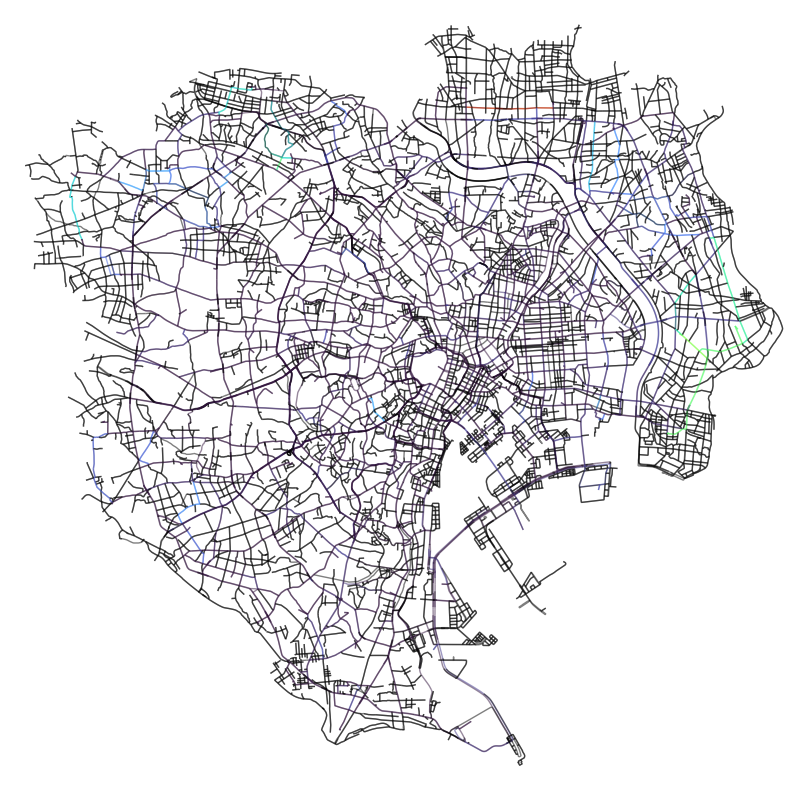

In [35]:
# set font
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Garamond', 'DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Times New Roman', 'Times', 'Palatino', 'Charter', 'serif']

# plot the edges
edge_colors = ox.plot.get_edge_colors_by_attr(tokyo_drive_network_flows, 'flows', cmap = 'turbo', na_color = 'None')

fig, ax = ox.plot_graph(tokyo_drive_network_flows, figsize = (12, 10), bgcolor = '#ffffff', edge_color = edge_colors, edge_alpha = 0.5, show = False, close = False, node_size = 0)

# Set the background color of the figure
fig.patch.set_facecolor('white')
# Set the background color of the axes
ax.set_facecolor('white')

# plt.savefig('documents/img/poi_density_edges.png', bbox_inches = 'tight', facecolor = 'white')


In [36]:
od_matrix_merged.columns

Index(['source', 'target', 'drive_time', 'drive_time_calib', 'drive_path',
       'drive_path_calib', 'multilayer_time', 'multilayer_path', 'rail', 'bus',
       'car', 'motorbike', 'bicycle', 'pedestrian', 'other', 'unknown',
       'total', 'public_transport', 'vehicle', 'total_edit',
       'driving_time_orig', 'driving_time_removed_Ginza',
       'driving_time_removed_Akihabara', 'driving_time_removed_Shinjuku',
       'driving_time_removed_Chuo_dori', 'driving_time_removed_all',
       'driving_time_removed_Ginza_nodes',
       'driving_time_removed_Akihabara_nodes',
       'driving_time_removed_Shinjuku_nodes',
       'driving_time_removed_Chuo_dori_nodes',
       'driving_time_removed_all_nodes', 'driving_path_orig',
       'driving_path_removed_Ginza', 'driving_path_removed_Akihabara',
       'driving_path_removed_Shinjuku', 'driving_path_removed_Chuo_dori',
       'driving_path_removed_all', 'driving_path_removed_Ginza_nodes',
       'driving_path_removed_Akihabara_nodes',
   